# Modeling HUPA0003 using rapid acting insulin and carb_input as exogenous variables 

## Get data and visualize it 

In [264]:
import pandas  as pd 
import matplotlib.pyplot as plt

In [265]:
data = pd.read_csv('../Data/Preprocessed/HUPA0003P.csv', sep=';')
data['time'] = pd.to_datetime(data['time'])

As portions of carbs are equivalent to 10g we convert it back into simple grams again in order to measure ICR 

In [266]:
data['carb_input'] = data['carb_input'] * 10 

Visualize it 

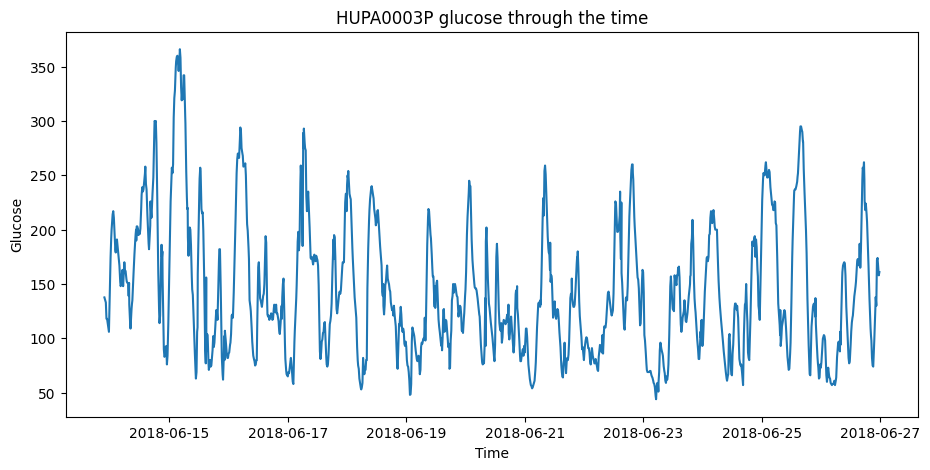

In [267]:
figure, ax = plt.subplots(1,1, figsize=(11, 5))
ax.plot(data['time'], data['glucose'])
ax.set(title='HUPA0003P glucose through the time', xlabel='Time', ylabel='Glucose')
plt.show()

## Insulin to Carb Ratio (ICR)

The ICR represents the number of grams of carbohydrate that 1 unit of rapid-acting insulin will cover. This ratio is highly individualized and varies from person to person.

Formula:
$
ICR = \text{Grams of Carbohydrate Eaten} / \text{Units of Rapid-Acting Insulin Taken}
$

Key Points:
- **Individual variation**: Each person has a unique ICR that may vary throughout the day
- **Clinical importance**: Proper ICR calculation is crucial for effective diabetes management
- **Monitoring**: Regular blood glucose monitoring helps adjust and validate ICR values

This ratio is fundamental for determining insulin dosing for meals and managing postprandial glucose levels.

In [268]:
import seaborn as sns

In [269]:
data.query('carb_input != 0 & bolus_volume_delivered != 0')

,time,glucose,calories,heart_rate,steps,basal_rate,bolus_volume_delivered,carb_input
120,2018-06-14 07:40:00,151.000000,6.52200,72.323529,0.0,0.066667,7.50,75.0
170,2018-06-14 11:50:00,196.000000,11.84830,76.222222,22.0,0.025000,1.75,35.0
203,2018-06-14 14:35:00,240.333333,8.26120,79.142857,6.0,0.066667,5.70,110.0
207,2018-06-14 14:55:00,224.333333,7.06550,88.909091,0.0,0.066667,1.50,20.0
282,2018-06-14 21:10:00,180.000000,14.02230,103.205128,0.0,0.075000,3.20,120.0
...,...,...,...,...,...,...,...,...
3458,2018-06-25 21:50:00,137.000000,11.19348,93.853659,7.0,0.075000,2.50,80.0
3578,2018-06-26 07:50:00,106.000000,8.34024,84.916667,0.0,0.066667,5.70,75.0
3674,2018-06-26 15:50:00,179.666667,7.13310,80.656250,0.0,0.066667,3.70,100.0
3696,2018-06-26 17:40:00,246.000000,17.99736,79.884615,166.0,0.029167,0.35,10.0


In [270]:
indexes = data.query('carb_input != 0 & bolus_volume_delivered != 0').index

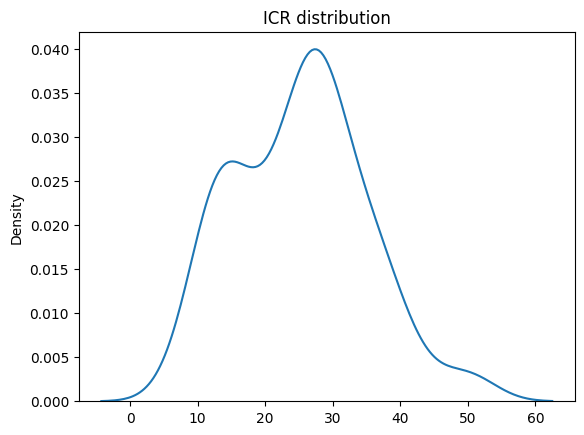

In [271]:
icr = data.loc[indexes]['carb_input'] / data.loc[indexes]['bolus_volume_delivered']
sns.kdeplot(icr)
plt.title('ICR distribution')
plt.show()

Now, let's add ICR as a dataset column

In [272]:
def get_ICR(x):
    carbs = x['carb_input']
    insulin = x['bolus_volume_delivered']
    if carbs == 0:
        return 0 
    elif insulin == 0:
        return 0
    else:
        return carbs/insulin

In [273]:
data['ICR'] = data.apply(get_ICR, axis=1)

In [274]:
data[data['ICR'] != 0]

,time,glucose,calories,heart_rate,steps,basal_rate,bolus_volume_delivered,carb_input,ICR
120,2018-06-14 07:40:00,151.000000,6.52200,72.323529,0.0,0.066667,7.50,75.0,10.000000
170,2018-06-14 11:50:00,196.000000,11.84830,76.222222,22.0,0.025000,1.75,35.0,20.000000
203,2018-06-14 14:35:00,240.333333,8.26120,79.142857,6.0,0.066667,5.70,110.0,19.298246
207,2018-06-14 14:55:00,224.333333,7.06550,88.909091,0.0,0.066667,1.50,20.0,13.333333
282,2018-06-14 21:10:00,180.000000,14.02230,103.205128,0.0,0.075000,3.20,120.0,37.500000
...,...,...,...,...,...,...,...,...,...
3458,2018-06-25 21:50:00,137.000000,11.19348,93.853659,7.0,0.075000,2.50,80.0,32.000000
3578,2018-06-26 07:50:00,106.000000,8.34024,84.916667,0.0,0.066667,5.70,75.0,13.157895
3674,2018-06-26 15:50:00,179.666667,7.13310,80.656250,0.0,0.066667,3.70,100.0,27.027027
3696,2018-06-26 17:40:00,246.000000,17.99736,79.884615,166.0,0.029167,0.35,10.0,28.571429


Let's visualize glucose, carbs, ICR and rapid-acting insulin at the same time, in order to visualize it properly, we normalize it 

In [275]:
def get_ticks(size_window, array_dates):
    index_ticks = []
    j = 0 
    i = 0
    while j != 288: ## A day contains 288 samples
        i = j
        index_ticks.append(i)
        j += size_window
    ticks = array_dates[index_ticks]
    label_ticks = ticks.dt.strftime('%Y/%m/%d %H:%M')
    return ticks, label_ticks

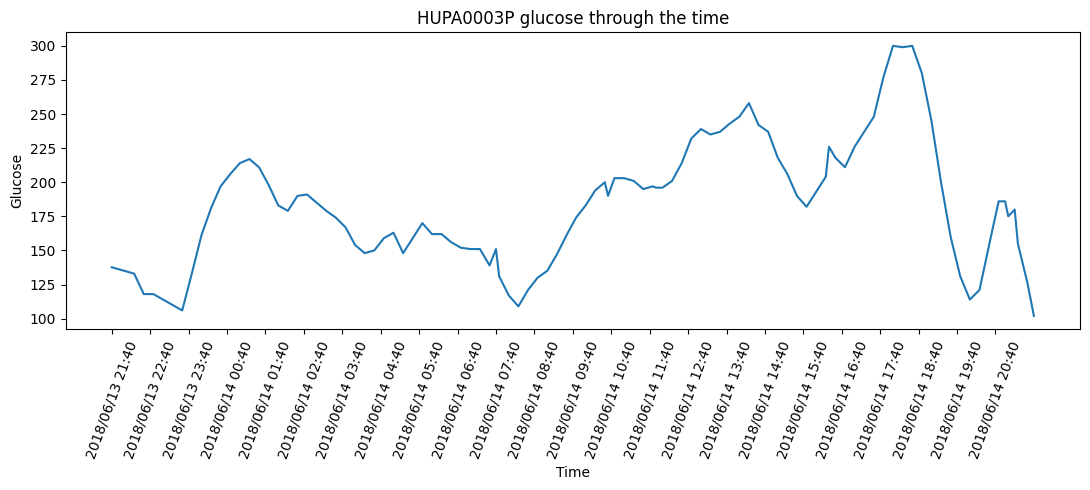

In [257]:
one_day = data[:289]
figure, ax = plt.subplots(1,1, figsize=(11, 5))
ticks, ticks_labels = get_ticks(12, array_dates=data['time'])
ax.plot(one_day['time'], one_day['glucose'])
ax.set(title='HUPA0003P glucose through the time', xlabel='Time', ylabel='Glucose')
ax.set_xticks(ticks)  
ax.set_xticklabels(ticks_labels, rotation=70)
plt.tight_layout()
plt.show()

In [276]:
def normalize(data):
    mean = data.mean()
    std = data.std()
    if std == 0:
        return data - mean
    return (data - mean) / std

## All variables together 

In [287]:
one_day_normalized = one_day.drop(labels='time', axis=1).apply(normalize, axis=0)

In [288]:
def plot_variables_normalized(normalized_df):
    figure, ax = plt.subplots(1,1, figsize=(11, 7))
    ticks, ticks_labels = get_ticks(12, array_dates=one_day['time'])
    for c in normalized_df.columns:
        ax.plot(one_day['time'], normalized_df[c], label=f'{c}')
    ax.set(title='The behaivor of all variables along one day', xlabel='Time', ylabel='Variables')
    ax.set_xticks(ticks)  
    ax.set_xticklabels(ticks_labels, rotation=70)
    plt.tight_layout()
    plt.legend()
    plt.show()

Firstly, plot all variables 

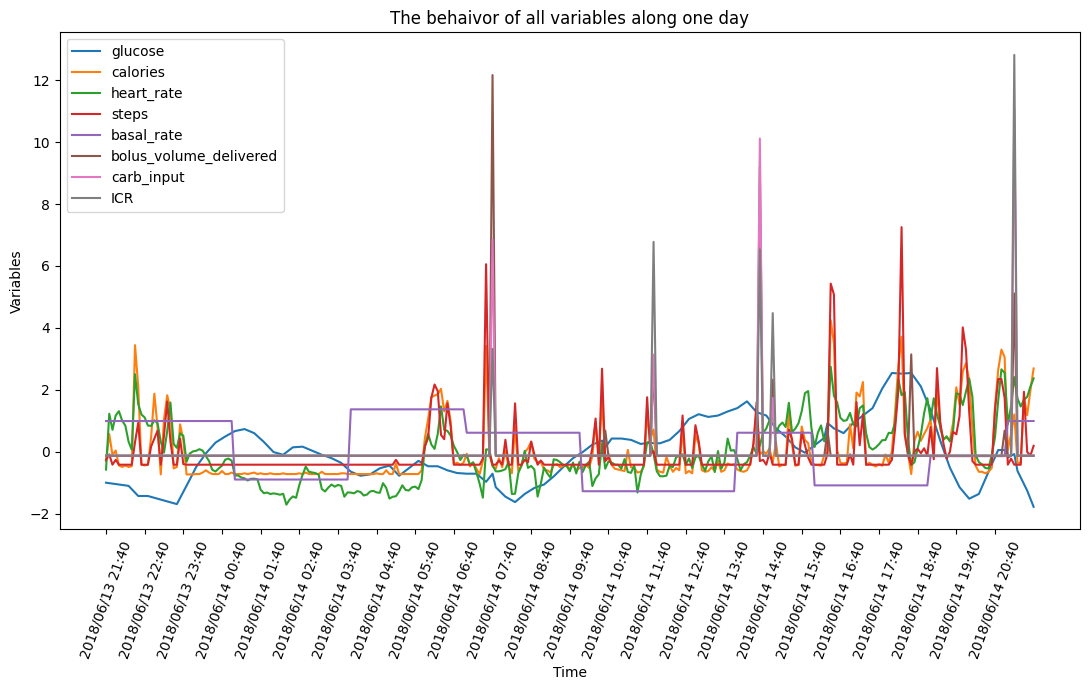

In [289]:
plot_variables_normalized(one_day_normalized)

Now just glucose, rapid-acting insulin and steps 

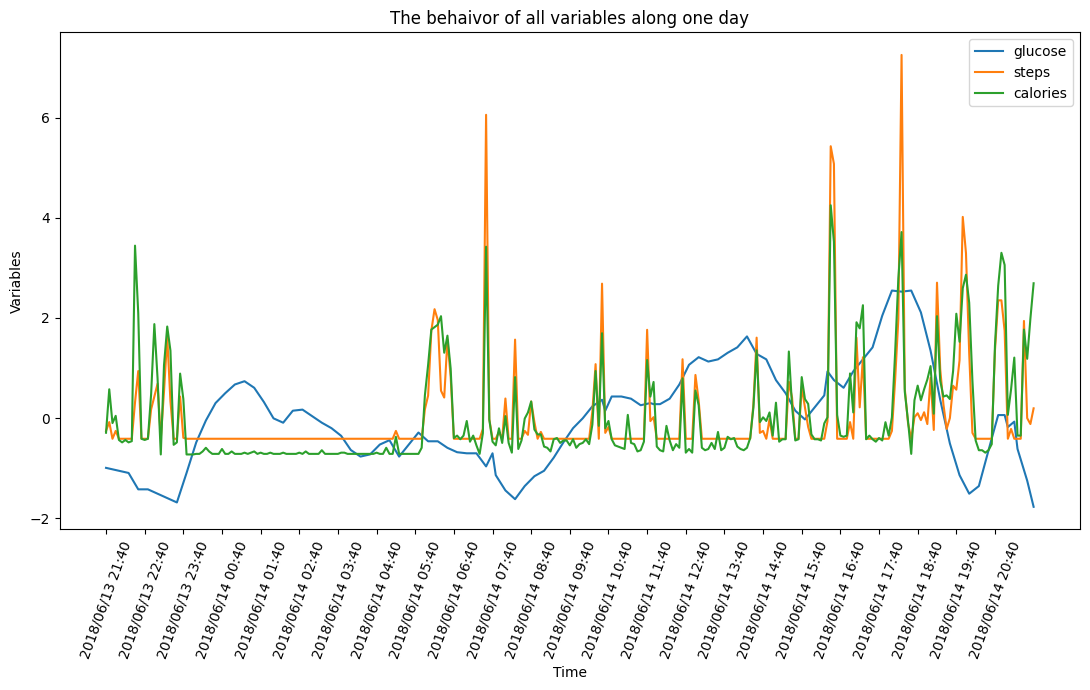

In [291]:
plot_variables_normalized(one_day_normalized[['glucose', 'steps', 'calories']])

As we could see above apparently, exists a correspondence between steps and glucose, in order to explore it, let's plot another day 

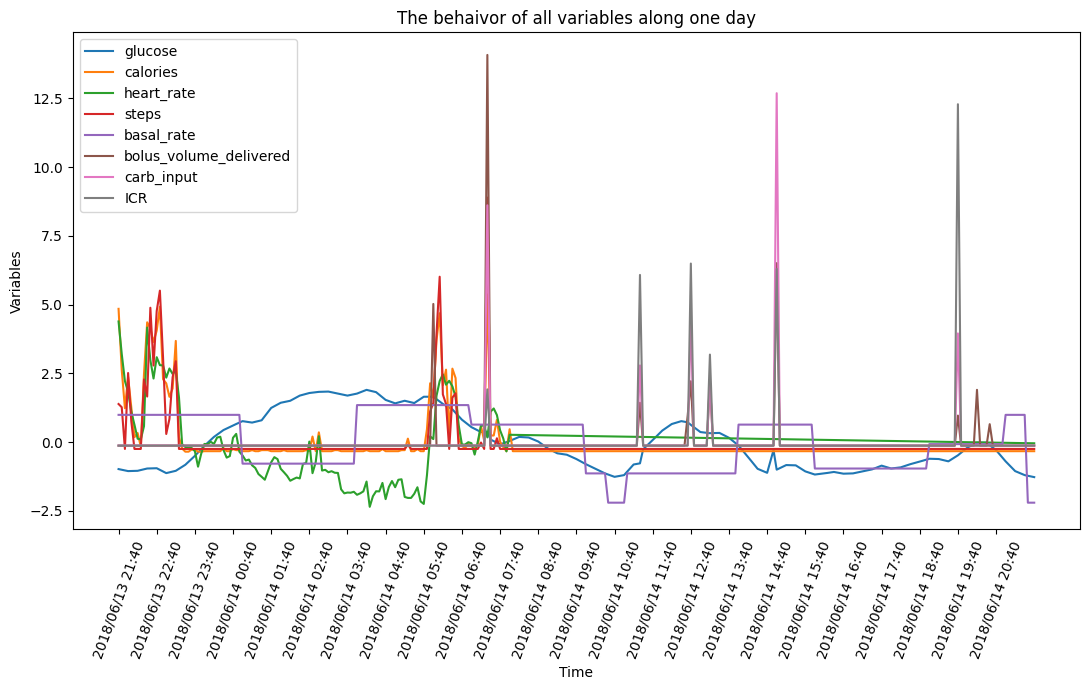

In [292]:
plot_variables_normalized(data[289:578].drop('time', axis=1).apply(normalize, axis=0))

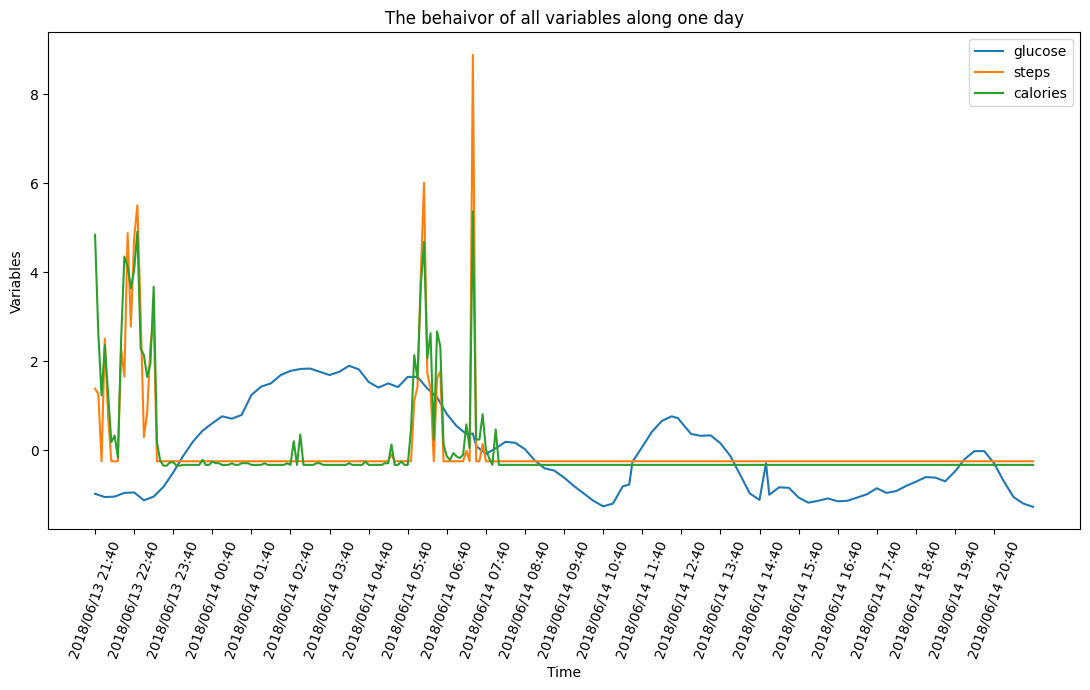

In [294]:
plot_variables_normalized(data[289:578].drop('time', axis=1)[['glucose', 'steps', 'calories']].apply(normalize, axis=0))

## Correlations 

In [ ]:
data

,time,glucose,calories,heart_rate,steps,basal_rate,bolus_volume_delivered,carb_input,ICR
0,2018-06-13 21:40:00,137.666667,7.32088,70.692308,8.0,0.075,0.0,0.0,0.0
1,2018-06-13 21:45:00,137.000000,11.19664,90.333333,17.0,0.075,0.0,0.0,0.0
2,2018-06-13 21:50:00,136.333333,8.18216,84.677419,0.0,0.075,0.0,0.0,0.0
3,2018-06-13 21:55:00,135.666667,8.82812,89.727273,8.0,0.075,0.0,0.0,0.0
4,2018-06-13 22:00:00,135.000000,6.67492,91.235294,0.0,0.075,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
3765,2018-06-26 23:25:00,160.666667,5.59674,68.875000,0.0,0.075,0.0,0.0,0.0
3766,2018-06-26 23:30:00,158.000000,5.48700,71.621622,0.0,0.075,0.0,0.0,0.0
3767,2018-06-26 23:35:00,159.000000,5.70648,71.692308,0.0,0.075,0.0,0.0,0.0
3768,2018-06-26 23:40:00,160.000000,5.48700,70.346154,0.0,0.075,0.0,0.0,0.0


In [ ]:
corr_matrix = data.corr(numeric_only=True)

In [ ]:
corr_matrix['glucose']

glucose                   1.000000
calories                 -0.113278
heart_rate               -0.097599
steps                    -0.067376
basal_rate               -0.010351
bolus_volume_delivered    0.026106
carb_input               -0.001757
ICR                      -0.004856
Name: glucose, dtype: float64

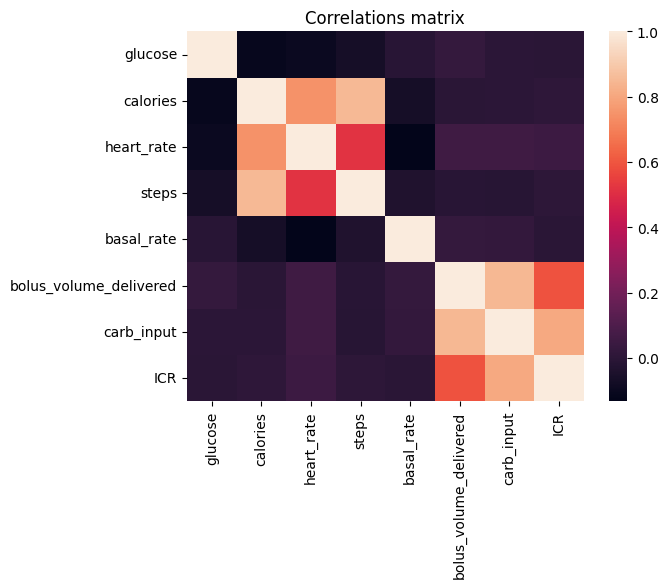

In [ ]:
sns.heatmap(corr_matrix)
plt.title('Correlations matrix')
plt.show()

## Define train and test size 

In [ ]:
train, test = data[:-5], data[-5:]

In [ ]:
train

,time,glucose,calories,heart_rate,steps,basal_rate,bolus_volume_delivered,carb_input,ICR
0,2018-06-13 21:40:00,137.666667,7.320880,70.692308,8.0,0.075,0.0,0.0,0.0
1,2018-06-13 21:45:00,137.000000,11.196640,90.333333,17.0,0.075,0.0,0.0,0.0
2,2018-06-13 21:50:00,136.333333,8.182160,84.677419,0.0,0.075,0.0,0.0,0.0
3,2018-06-13 21:55:00,135.666667,8.828120,89.727273,8.0,0.075,0.0,0.0,0.0
4,2018-06-13 22:00:00,135.000000,6.674920,91.235294,0.0,0.075,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
3760,2018-06-26 23:00:00,174.000000,13.278540,80.921053,55.0,0.075,0.0,0.0,0.0
3761,2018-06-26 23:05:00,171.333333,12.181140,82.472222,39.0,0.075,0.0,0.0,0.0
3762,2018-06-26 23:10:00,168.666667,12.839580,76.694444,62.0,0.075,0.0,0.0,0.0
3763,2018-06-26 23:15:00,166.000000,14.595419,87.888889,68.0,0.075,0.0,0.0,0.0


In [ ]:
test

,time,glucose,calories,heart_rate,steps,basal_rate,bolus_volume_delivered,carb_input,ICR
3765,2018-06-26 23:25:00,160.666667,5.59674,68.875000,0.0,0.075,0.0,0.0,0.0
3766,2018-06-26 23:30:00,158.000000,5.48700,71.621622,0.0,0.075,0.0,0.0,0.0
3767,2018-06-26 23:35:00,159.000000,5.70648,71.692308,0.0,0.075,0.0,0.0,0.0
3768,2018-06-26 23:40:00,160.000000,5.48700,70.346154,0.0,0.075,0.0,0.0,0.0
3769,2018-06-26 23:45:00,161.000000,5.48700,71.437500,0.0,0.075,0.0,0.0,0.0


## AIC and BIC criteria 

Now, we generate all combinations (p=4,q=4) to apply both AIC and BIC

In [ ]:
from itertools import product

range_start = 0
range_end = 5
combinations = list(product(range(range_start, range_end), repeat=2))

In [ ]:
combinations

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (1, 0),
 (1, 1),
 (1, 2),
 (1, 3),
 (1, 4),
 (2, 0),
 (2, 1),
 (2, 2),
 (2, 3),
 (2, 4),
 (3, 0),
 (3, 1),
 (3, 2),
 (3, 3),
 (3, 4),
 (4, 0),
 (4, 1),
 (4, 2),
 (4, 3),
 (4, 4)]

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def optimize_ARIMA(endog: pd. Series, exog: pd.Series, order_list: list, d: int) -> pd.DataFrame:
    results = []

    for order in order_list:
        try:
            model = SARIMAX(endog, exog, order=(order [0], d, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue
        aic = model.aic
        bic = model.bic
        results.append([order, round(aic, 2), round(bic, 2)])

    result_df = pd.DataFrame (results)
    result_df.columns = ['(p,q)', 'AIC', 'BIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True). reset_index(drop=True)
    result_2_df = result_df.sort_values(by='BIC', ascending=True). reset_index(drop=True)
    return result_df[['(p,q)', 'AIC']], result_2_df[['(p,q)', 'BIC']]

In [ ]:
aic, bic = optimize_ARIMA(endog=train['glucose'], exog=train['bolus_volume_delivered'], order_list=combinations, d=0)

/home/arturo27/.local/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/arturo27/.local/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/arturo27/.local/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/arturo27/.local/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/arturo27/.local/lib/python3.13/site-packages/statsmodels/base/

In [ ]:
aic

,"(p,q)",AIC
0,"(2, 3)",22278.38
1,"(2, 4)",22278.97
2,"(3, 4)",22287.23
3,"(4, 0)",22290.02
4,"(4, 4)",22313.74
5,"(3, 2)",22336.10
6,"(2, 2)",22349.02
7,"(3, 3)",22362.77
8,"(2, 1)",22365.38
9,"(1, 4)",22444.80


In [ ]:
bic

,"(p,q)",BIC
0,"(2, 3)",22322.01
1,"(4, 0)",22327.42
2,"(2, 4)",22328.84
3,"(3, 4)",22343.34
4,"(4, 4)",22376.08
5,"(3, 2)",22379.74
6,"(2, 2)",22386.43
7,"(2, 1)",22396.55
8,"(3, 3)",22412.64
9,"(1, 4)",22488.44


## Residual analysis 

In [ ]:
from scipy.stats import norm
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox
import numpy as np 

In [ ]:
best_model = SARIMAX(endog=train['glucose'], exog=train['bolus_volume_delivered'], order=(2,0,3), simple_differencing=False).fit(disp=False)
residuals = best_model.resid
predictions_train = best_model.fittedvalues

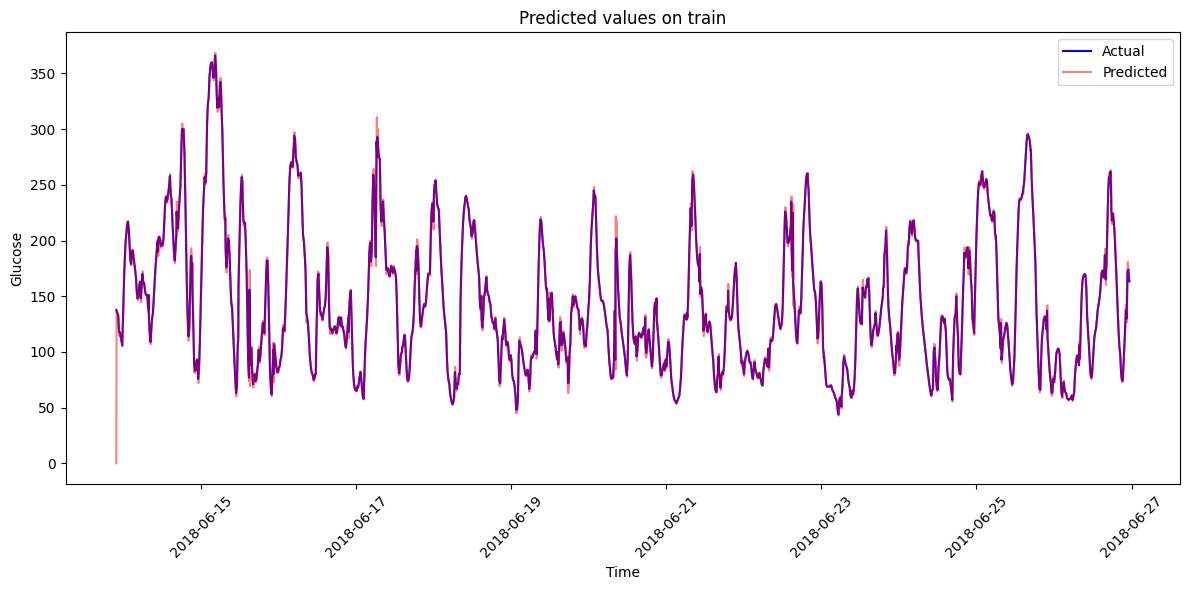

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(train['time'], train['glucose'], label='Actual', color='blue')
plt.plot(train['time'], predictions_train, label='Predicted', color='red', alpha=0.5)
plt.title('Predicted values on train')
plt.xlabel('Time')
plt.ylabel('Glucose')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Qualitative analysis

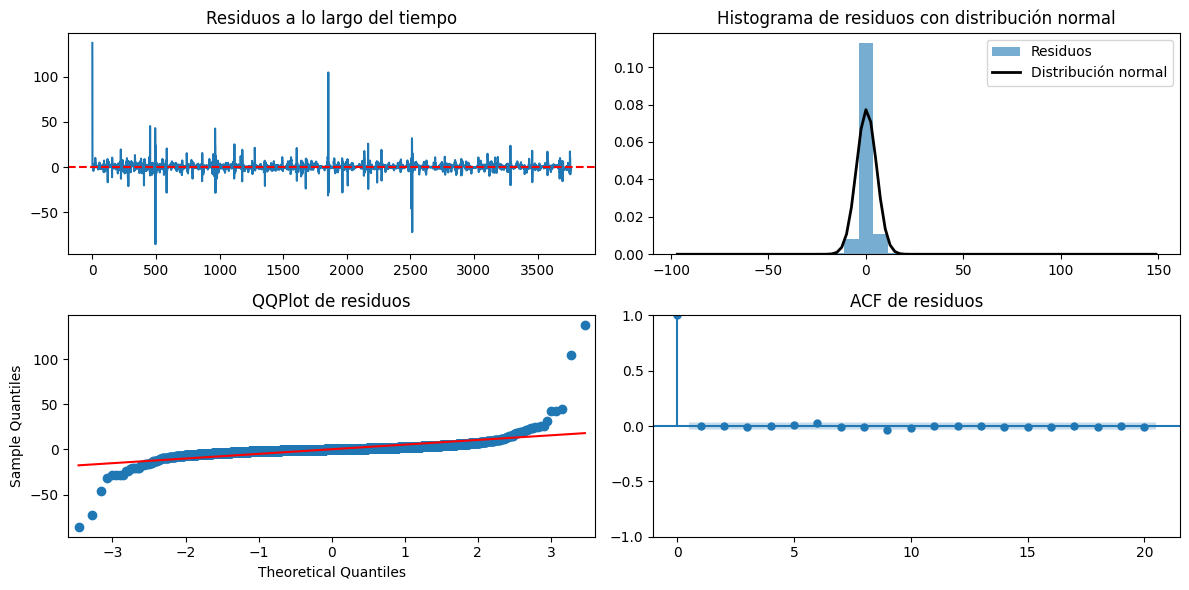

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.plot(residuals)
plt.title("Residuos a lo largo del tiempo")
plt.axhline(y=0, color='r', linestyle='--')

plt.subplot(2, 2, 2)
plt.hist(residuals, bins=30, density=True, alpha=0.6, label='Residuos')
mu, std = np.mean(residuals), np.std(residuals)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2, label='Distribución normal')
plt.title("Histograma de residuos con distribución normal")
plt.legend()

plt.subplot(2, 2, 3)
sm.qqplot(residuals, line='s', ax=plt.gca())
plt.title("QQPlot de residuos")

plt.subplot(2, 2, 4)
sm.graphics.tsa.plot_acf(residuals, lags=20, alpha=0.05, ax=plt.gca())
plt.title("ACF de residuos")

plt.tight_layout()
plt.show()

### Quantitative analysis 

We Ljung-Box test establish that the residuals are independently distributed as null hypothesis 

In [ ]:
lags = np.arange(1, 11, 1)
df_residuals = acorr_ljungbox(residuals, lags)
df_residuals['Lag k'] = np.arange(1, 11)

In [ ]:
df_residuals

,lb_stat,lb_pvalue,Lag k
1,0.005022,0.943503,1
2,0.007391,0.996311,2
3,0.156027,0.984355,3
4,0.226443,0.994054,4
5,0.444892,0.994002,5
6,3.268823,0.774429,6
7,3.602956,0.824203,7
8,4.219835,0.836764,8
9,9.339773,0.406520,9
10,10.708609,0.380666,10


## Make predictions 

In [ ]:
print(best_model.summary())

                               SARIMAX Results                                
Dep. Variable:                glucose   No. Observations:                 3765
Model:               SARIMAX(2, 0, 3)   Log Likelihood              -11132.190
Date:                Wed, 01 Oct 2025   AIC                          22278.379
Time:                        23:30:03   BIC                          22322.014
Sample:                             0   HQIC                         22293.894
                               - 3765                                         
Covariance Type:                  opg                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
bolus_volume_delivered     0.4079      0.025     16.503      0.000       0.359       0.456
ar.L1                      1.7993      0.015    121.591      0.000       1.770       1.828
ar.L

In [ ]:
test_predicted = best_model.predict(
    start=len(train), 
    end=len(train)+len(test)-1,
    exog=test['bolus_volume_delivered']
)

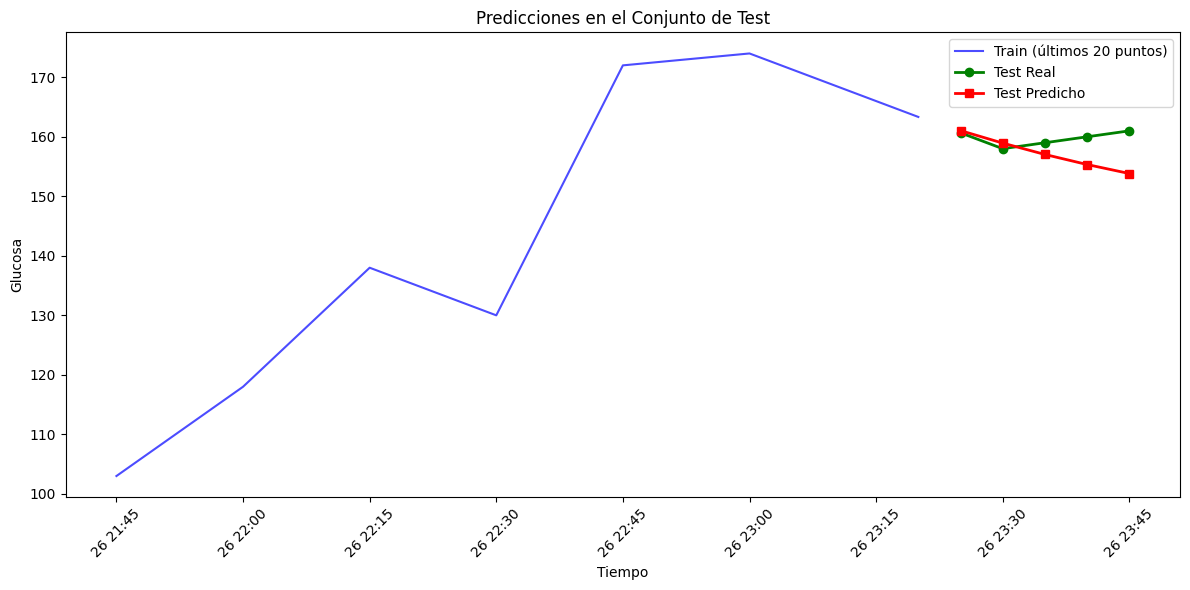


Métricas de evaluación en el conjunto de test:
MSE: 15.6296
RMSE: 3.9534
MAE: 3.0246


In [ ]:
# Visualizar las predicciones del test
plt.figure(figsize=(12, 6))

# Mostrar los últimos puntos del train para continuidad
train_tail = train.tail(20)
plt.plot(train_tail['time'], train_tail['glucose'], label='Train (últimos 20 puntos)', color='blue', alpha=0.7)

# Mostrar test real y predicciones
plt.plot(test['time'], test['glucose'], label='Test Real', color='green', marker='o', linewidth=2)
plt.plot(test['time'], test_predicted, label='Test Predicho', color='red', marker='s', linewidth=2)

plt.title('Predicciones en el Conjunto de Test')
plt.xlabel('Tiempo')
plt.ylabel('Glucosa')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Calcular métricas de error para el test
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

test_mse = mean_squared_error(test['glucose'], test_predicted)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(test['glucose'], test_predicted)

print(f"\nMétricas de evaluación en el conjunto de test:")
print(f"MSE: {test_mse:.4f}")
print(f"RMSE: {test_rmse:.4f}")
print(f"MAE: {test_mae:.4f}")

In [ ]:
# Crear DataFrame comparativo para análisis detallado
comparison_df = pd.DataFrame({
    'time': test['time'],
    'actual': test['glucose'].values,
    'predicted': test_predicted.values,
    'error': test['glucose'].values - test_predicted.values,
    'abs_error': np.abs(test['glucose'].values - test_predicted.values),
    'exog_insulin': test['bolus_volume_delivered'].values
})

print("Comparación detallada Test vs Predicciones:")
print(comparison_df)

Comparación detallada Test vs Predicciones:
                    time      actual   predicted     error  abs_error  \
3765 2018-06-26 23:25:00  160.666667  161.040847 -0.374181   0.374181   
3766 2018-06-26 23:30:00  158.000000  158.938236 -0.938236   0.938236   
3767 2018-06-26 23:35:00  159.000000  157.028309  1.971691   1.971691   
3768 2018-06-26 23:40:00  160.000000  155.337423  4.662577   4.662577   
3769 2018-06-26 23:45:00  161.000000  153.823601  7.176399   7.176399   

      exog_insulin  
3765           0.0  
3766           0.0  
3767           0.0  
3768           0.0  
3769           0.0  
